In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from pprint import pprint
import re
import json
import gzip
class LTEParser:
    _mapa = {
        "B": "#Bearer",
        "T": "TimeStamp",
        "TX": "Transmission",
        "RX": "Receiver",
        "D": "Delay",
        "ID": "#Packet",
        "DST": "Destiny",
        "SRC": "Source",
        "SIZE": "Size"
    }
    @staticmethod
    def parse(inFile, flowDuration = 100):
        #VIDEO
        videoAverages = []
        videoFairness = []
        videoDelay = []
        videoJitter = []
        videoPLR = []
        #VOICE
        voiceAverages = []
        voiceFairness = []
        voiceDelay = []
        voiceJitter = []
        voicePLR = []
        #WEB
        WebAverages = []
        WebFairness = []
        WebDelay = []
        WebJitter = []
        WebPLR = []
        #CBR
        CBRAverages = []
        CBRFairness = []
        CBRDelay = []
        CBRJitter = []
        CBRPLR = []
        #GERAL
        packetLoss = []
        for sfile in inFile:
            content = ""
            print("Opening file: " + sfile)
            with gzip.open(sfile, 'rb') as file:
                content = file.read()
                content = content.decode('utf-8')
            print("Parsing file ...", end="")
            txContent, rxContent = LTEParser._parse(content)
            info = LTEParser.getFairnessIndex(rxContent, flowDuration)
            packetLossInfo = LTEParser.getPacketLossRatio(txContent, rxContent)
            delayInfo = LTEParser.getDelayJitter(rxContent)
            #VIDEO
            videoAverages.append(info['VIDEO']['Average'])
            videoFairness.append(info['VIDEO']['FairnessIndex'])
            videoDelay.append(delayInfo['VIDEO']['Average'])
            videoJitter.append(delayInfo['VIDEO']['StD'])
            videoPLR.append(packetLossInfo[1]['VIDEO'])
            #VOICE
            voiceAverages.append(info['VOIP']['Average'])
            voiceFairness.append(info['VOIP']['FairnessIndex'])
            voiceDelay.append(delayInfo['VOIP']['Average'])
            voiceJitter.append(delayInfo['VOIP']['StD'])
            voicePLR.append(packetLossInfo[1]['VOIP'])
            #WEBBUF
            WebAverages.append(info['WEB']['Average'])
            WebFairness.append(info['WEB']['FairnessIndex'])
            WebDelay.append(delayInfo['WEB']['Average'])
            WebJitter.append(delayInfo['WEB']['StD'])
            WebPLR.append(packetLossInfo[1]['WEB'])
            #CBRBUF
            CBRAverages.append(info['CBR']['Average'])
            CBRFairness.append(info['CBR']['FairnessIndex'])
            CBRDelay.append(delayInfo['CBR']['Average'])
            CBRJitter.append(delayInfo['CBR']['StD'])
            CBRPLR.append(packetLossInfo[1]['CBR'])
            #GERAL
            packetLoss.append(packetLossInfo[0])
        return [#VIDEO
                (sum(videoAverages)/len(videoAverages)),
                (sum(videoFairness)/len(videoFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                (sum(videoPLR)/len(videoPLR)),
                #VOICE
                (sum(voiceAverages)/len(voiceAverages)),
                (sum(voiceFairness)/len(voiceFairness)),
                (sum(voiceDelay)/len(voiceDelay)),
                (sum(voiceJitter)/len(voiceJitter)),
                (sum(voicePLR)/len(voicePLR)),
                #WEB
                (sum(WebAverages)/len(WebAverages)),
                (sum(WebFairness)/len(WebFairness)),
                (sum(WebDelay)/len(WebDelay)),
                (sum(WebJitter)/len(WebJitter)),
                (sum(WebPLR)/len(WebPLR)),
                #CBR
                (sum(CBRAverages)/len(CBRAverages)),
                (sum(CBRFairness)/len(CBRFairness)),
                (sum(CBRDelay)/len(CBRDelay)),
                (sum(CBRJitter)/len(CBRJitter)),
                (sum(CBRPLR)/len(CBRPLR)),
                #GERAL
                packetLoss]
    @staticmethod
    def _parse(content):
        txContent = LTEParser.parseTX(content)
        rxContent = LTEParser.parseRX(content)
        print("Done")
        return txContent, rxContent
    
    @staticmethod
    def parseTX(content):
        matches = re.findall(r"(^TX.+)", content, re.MULTILINE)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        keys = dictPacketType.keys()
        for match in matches:
            values = match.split(' ')
            if values[1] in keys:
                tamanho = len(values)
                dic = {}
                for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                    dic[LTEParser._mapa[values[i]]] = values[i+1]
                dic = dict(sorted(dic.items(), key=lambda x: x[0]))
                dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
        
    @staticmethod        
    def parseRX(content):
        matches = re.findall(r"(^RX.+)", content, re.MULTILINE)
        if(matches == []):
            raise Exception("No matches in content for RX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        keys = dictPacketType.keys()
        for match in matches:
            values = match.split(' ')
            if values[1] in keys:
                tamanho = len(values)
                dic = {}
                for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                    dic[LTEParser._mapa[values[i]]] = values[i+1]
                dic = dict(sorted(dic.items(), key=lambda x: x[0]))
                dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
    
    @staticmethod
    def getPacketLossRatio(txContent, rxContent):
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        tx_pkts = 0
        rx_pkts = 0
        for key in txContent:
            keytx = len(txContent[key])
            tx_pkts += keytx
            keyrx = len(rxContent[key])
            rx_pkts += keyrx
            keyPLR = ((keytx - keyrx) / (keytx if keytx != 0 else 1)) * 100
            dictPacketType[key] = keyPLR
        plr = ((tx_pkts - rx_pkts) / tx_pkts) * 100
        return plr, dictPacketType
    
    @staticmethod
    def getDelayJitter(rxContent):
        delayPerApp = {}
        for app in rxContent:
            delayPerApp[app] = {"Sum": 0, "Average": 0, "StD": 0}
            delayPerApp[app]["Sum"] = sum(float(item["Delay"]) for item in rxContent[app])
            tamanho = len(rxContent[app])
            delayPerApp[app]["Average"] = delayPerApp[app]["Sum"]/tamanho if tamanho != 0 else 0
            delayPerApp[app]["StD"] = sum((float(item["Delay"]) - delayPerApp[app]["Average"])**2 for item in rxContent[app])/ (tamanho - 1) if tamanho != 0 else 0
        return delayPerApp
    
    @staticmethod
    def getGoodput(rxContent, flowDuration):
        gputPerApp = {}
        for app in rxContent:
            gputPerApp[app] = {"Sum": 0, "Average": 0}
            gputPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
            gputPerApp[app]["Average"] = (gputPerApp[app]["Sum"])/flowDuration
        return gputPerApp
    
    @staticmethod
    def getThroughput(rxContent, flowDuration):
        tputPerApp = {}
        for app in rxContent:
            tputPerApp[app] = {"Sum": 0, "Average": 0}
            tputPerApp[app]["Sum"] = sum((float(item["Size"]) + 5)*8 for item in rxContent[app])
            tputPerApp[app]["Average"] = (tputPerApp[app]["Sum"])/flowDuration
        return tputPerApp
    
    @staticmethod
    def getSpectralEff():
        pass
    
    @staticmethod
    def getFairnessIndex(rxContent, flowDuration):
        fairnessPerApp = {}
        for app in rxContent:
            fairnessPerApp[app] = {"Sum": 0, "Average": 0, "SumSquared": 0, "SquaredSum": 0, "FairnessIndex": 0}
            if(len(rxContent[app]) > 0):
                fairnessPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
                fairnessPerApp[app]["Average"] = (fairnessPerApp[app]["Sum"])/flowDuration
                fairnessPerApp[app]["SumSquared"] = sum(pow(float(item["Size"])*8,2) for item in rxContent[app])
                fairnessPerApp[app]["SquaredSum"] = pow(fairnessPerApp[app]["Sum"], 2)
                division = (len(rxContent[app]) * fairnessPerApp[app]["SumSquared"])
                fairnessPerApp[app]["FairnessIndex"] = fairnessPerApp[app]["SquaredSum"] / division if division > 0 else 1
        return fairnessPerApp

In [2]:
base = "../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition"
ext = ".gz"
until = 21
users = 51
files = {
         1: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         2: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}, 
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         3: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         4: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         5: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
         6: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
         7: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             }
        }
for sched in range(1,8):
    for ue in range(10, users, 10):
        for vel in [3]:
            for count in range(1,until):
                file = "/SCHED_" + str(sched) + "_UE_" + str(ue) + "_V_" + str(vel) +"_D_.1_" + str(count)
                filename = base + file + ext
                files[sched][vel][ue].append(filename)

In [3]:
#VIDEO
GPUTSVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
FAIRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
DELAYVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
JITTERVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
PLRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
#VOICE
GPUTSVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
FAIRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
DELAYVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
JITTERVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
PLRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
#WEB
GPUTSWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
FAIRWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
DELAYWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
JITTERWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
PLRWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
#CBR
GPUTSCBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
FAIRCBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
DELAYCBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
JITTERCBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
PLRCBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
#GERAL
PACKETLOSS = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[]}
for sched in GPUTSVIDEO:
    for ue in range(10, users, 10):
        info = LTEParser.parse(files[sched][3][ue], 100)
        #VIDEO
        GPUTSVIDEO[sched].append(info[0])
        FAIRVIDEO[sched].append(info[1])
        DELAYVIDEO[sched].append(info[2])
        JITTERVIDEO[sched].append(info[3])
        PLRVIDEO[sched].append(info[4])
        #VOICE
        GPUTSVOICE[sched].append(info[5])
        FAIRVOICE[sched].append(info[6])
        DELAYVOICE[sched].append(info[7])
        JITTERVOICE[sched].append(info[8])
        PLRVOICE[sched].append(info[9])
        #WEB
        GPUTSWEB[sched].append(info[10])
        FAIRWEB[sched].append(info[11])
        DELAYWEB[sched].append(info[12])
        JITTERWEB[sched].append(info[13])
        PLRWEB[sched].append(info[14])
        #CBR
        GPUTSCBR[sched].append(info[15])
        FAIRCBR[sched].append(info[16])
        DELAYCBR[sched].append(info[17])
        JITTERCBR[sched].append(info[18])
        PLRCBR[sched].append(info[19])
        #GERAL
        PACKETLOSS[sched].append(info[20])
    #VIDEO
    GPUTSVIDEO[sched] = np.array(GPUTSVIDEO[sched], dtype=np.float32)
    FAIRVIDEO[sched] = np.array(FAIRVIDEO[sched], dtype=np.float32)
    DELAYVIDEO[sched] = np.array(DELAYVIDEO[sched], dtype = np.float32)
    JITTERVIDEO[sched] = np.array(JITTERVIDEO[sched], dtype = np.float32)
    PLRVIDEO[sched] = np.array(PLRVIDEO[sched], dtype = np.float32)
    #VOICE
    GPUTSVOICE[sched] = np.array(GPUTSVOICE[sched], dtype=np.float32)
    FAIRVOICE[sched] = np.array(FAIRVOICE[sched], dtype=np.float32)
    DELAYVOICE[sched] = np.array(DELAYVOICE[sched], dtype = np.float32)
    JITTERVOICE[sched] = np.array(JITTERVOICE[sched], dtype = np.float32)
    PLRVOICE[sched] = np.array(PLRVOICE[sched], dtype = np.float32)
    #WEB
    GPUTSWEB[sched] = np.array(GPUTSWEB[sched], dtype=np.float32)
    FAIRWEB[sched] = np.array(FAIRWEB[sched], dtype=np.float32)
    DELAYWEB[sched] = np.array(DELAYWEB[sched], dtype = np.float32)
    JITTERWEB[sched] = np.array(JITTERWEB[sched], dtype = np.float32)
    PLRWEB[sched] = np.array(PLRWEB[sched], dtype = np.float32)
    #CBR
    GPUTSCBR[sched] = np.array(GPUTSCBR[sched], dtype=np.float32)
    FAIRCBR[sched] = np.array(FAIRCBR[sched], dtype=np.float32)
    DELAYCBR[sched] = np.array(DELAYCBR[sched], dtype = np.float32)
    JITTERCBR[sched] = np.array(JITTERCBR[sched], dtype = np.float32)
    PLRCBR[sched] = np.array(PLRCBR[sched], dtype = np.float32)
    #GERAL
    PACKETLOSS[sched] = np.array(PACKETLOSS[sched], dtype=np.float32)

Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_8.gz
Parsi

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_10.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_1_U

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_14.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_15.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_50_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_50_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_50_V_3_D_.1_18.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_50_V_3_D_.1_19.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_2_UE_50_V_3_D_.1_20.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_10_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_10_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_3_UE_4

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_10.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_U

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_14.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_15.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_5_UE_30_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_5_UE_30_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_5_UE_30_V_3_D_.1_18.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_5_UE_30_V_3_D_.1_19.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_5_UE_30_V_3_D_.1_20.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_5

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_2

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_10.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_6_U

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_7_UE_30_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_7_UE_30_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_7_UE_30_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_7_UE_30_V_3_D_.1_14.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_7_UE_30_V_3_D_.1_15.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_7_UE_30_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED_7_UE_30_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P.25_.75WebApp_ConstantPosition/SCHED

# VIDEO
## GPUT

In [4]:
MEGAVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for sched in GPUTSVIDEO:
    MEGAVIDEO[sched] = np.true_divide(GPUTSVIDEO[sched], 1e+6)

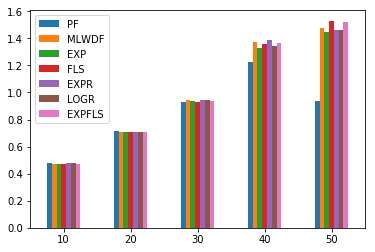

In [5]:
dfGPUTVIDEO = pd.DataFrame({'PF': MEGAVIDEO[1], 'MLWDF': MEGAVIDEO[2], 'EXP': MEGAVIDEO[3],
                       'FLS': MEGAVIDEO[4], 'EXPR': MEGAVIDEO[5], 'LOGR': MEGAVIDEO[6], 'EXPFLS': MEGAVIDEO[7]},
                      index=[10,20,30,40,50])
plot = dfGPUTVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVideo.pdf", bbox_inches='tight')

In [6]:
dfGPUTVIDEO

,PF,MLWDF,EXP,FLS,EXPR,LOGR,EXPFLS
10,0.475540,0.474927,0.472560,0.473163,0.475060,0.476018,0.470940
20,0.712349,0.709557,0.708889,0.710853,0.711344,0.709798,0.709453
30,0.927160,0.943485,0.935570,0.929951,0.940789,0.940718,0.939005
40,1.222168,1.374906,1.328800,1.355483,1.389143,1.345349,1.362070
50,0.933072,1.479332,1.443486,1.529733,1.457829,1.457627,1.518929


## Delay

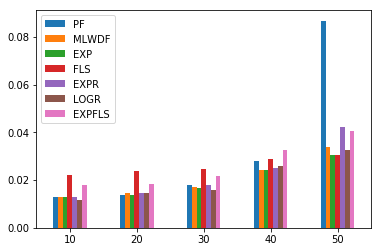

In [7]:
dfDELAYVIDEO = pd.DataFrame({'PF': DELAYVIDEO[1], 'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6], 'EXPFLS': DELAYVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideoPF.pdf", bbox_inches='tight')

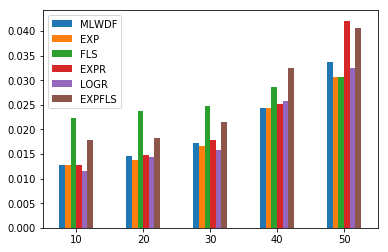

In [8]:
dfDELAYVIDEO = pd.DataFrame({'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5],
                             'LOGR': DELAYVIDEO[6], 'EXPFLS': DELAYVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideo.pdf", bbox_inches='tight')

## JITTER

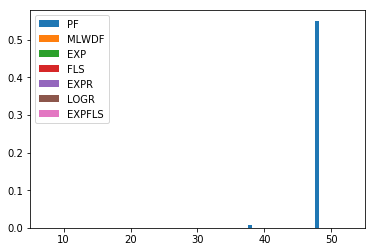

In [9]:
dfJITTERVIDEO = pd.DataFrame({'PF': JITTERVIDEO[1], 'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6], 'EXPFLS': JITTERVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideoPF.pdf", bbox_inches='tight')

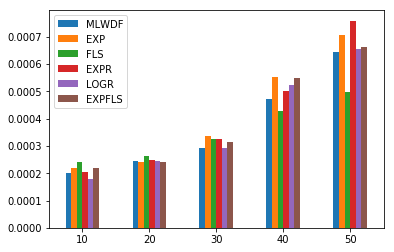

In [10]:
dfJITTERVIDEO = pd.DataFrame({'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5],
                            'LOGR': JITTERVIDEO[6], 'EXPFLS': JITTERVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideo.pdf", bbox_inches='tight')

## FAIRNESS

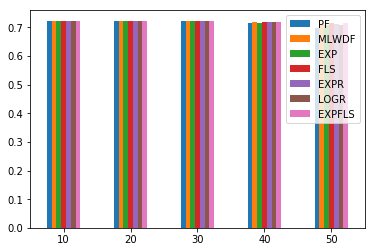

In [11]:
dfFAIRVIDEO = pd.DataFrame({'PF': FAIRVIDEO[1], 'MLWDF': FAIRVIDEO[2], 'EXP': FAIRVIDEO[3],
                            'FLS': FAIRVIDEO[4], 'EXPR': FAIRVIDEO[5], 'LOGR': FAIRVIDEO[6],
                           'EXPFLS': FAIRVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfFAIRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVideo.pdf", bbox_inches='tight')

## PLR

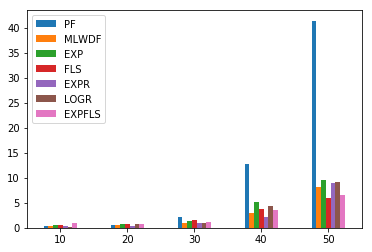

In [12]:
dfPLRVIDEO = pd.DataFrame({'PF': PLRVIDEO[1], 'MLWDF': PLRVIDEO[2], 'EXP': PLRVIDEO[3],
                            'FLS': PLRVIDEO[4], 'EXPR': PLRVIDEO[5], 'LOGR': PLRVIDEO[6],
                          'EXPFLS': PLRVIDEO[7]},
                           index=[10,20,30,40,50])
plot = dfPLRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossVideo.pdf", bbox_inches='tight')

# VOIP
## GPUT

In [13]:
MEGAVOIP = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for sched in GPUTSVOICE:
    MEGAVOIP[sched] = np.true_divide(GPUTSVOICE[sched], 1e+6)

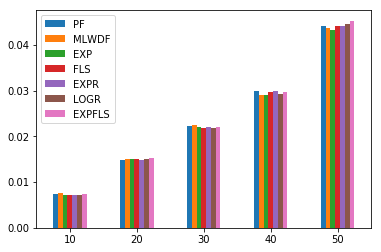

In [14]:
dfGPUTVOICE = pd.DataFrame({'PF': MEGAVOIP[1], 'MLWDF': MEGAVOIP[2], 'EXP': MEGAVOIP[3],
                       'FLS': MEGAVOIP[4], 'EXPR': MEGAVOIP[5], 'LOGR': MEGAVOIP[6], 'EXPFLS': MEGAVOIP[7]},
                      index=[10,20,30,40,50])
plot = dfGPUTVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVoIP.pdf", bbox_inches='tight')

## Delay

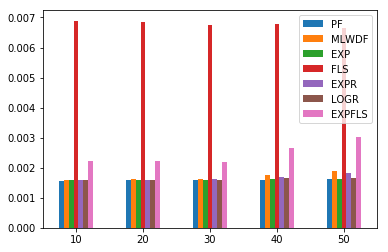

In [15]:
dfDELAYVOICE = pd.DataFrame({'PF': DELAYVOICE[1], 'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6],
                            'EXPFLS': DELAYVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIPPF.pdf", bbox_inches='tight')

## Jitter

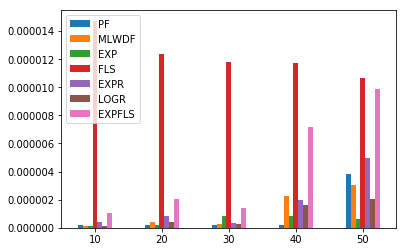

In [16]:
dfJITTERVOICE = pd.DataFrame({'PF': JITTERVOICE[1], 'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6],
                             'EXPFLS': JITTERVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIPPF.pdf", bbox_inches='tight')

## FAIRNESS

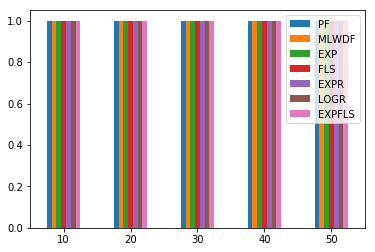

In [17]:
dfFAIRVOICE = pd.DataFrame({'PF': FAIRVOICE[1], 'MLWDF': FAIRVOICE[2], 'EXP': FAIRVOICE[3],
                            'FLS': FAIRVOICE[4], 'EXPR': FAIRVOICE[5], 'LOGR': FAIRVOICE[6],
                           'EXPFLS': FAIRVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfFAIRVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVoice.pdf", bbox_inches='tight')

## PLR

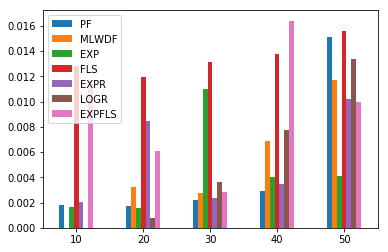

In [18]:
dfPLRVOICE = pd.DataFrame({'PF': PLRVOICE[1], 'MLWDF': PLRVOICE[2], 'EXP': PLRVOICE[3],
                            'FLS': PLRVOICE[4], 'EXPR': PLRVOICE[5], 'LOGR': PLRVOICE[6],
                          'EXPFLS': PLRVOICE[7]},
                           index=[10,20,30,40,50])
plot = dfPLRVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossVoice.pdf", bbox_inches='tight')

# WEB
## GPUT

In [19]:
MEGAWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for sched in GPUTSWEB:
    MEGAWEB[sched] = np.true_divide(GPUTSWEB[sched], 1e+6)

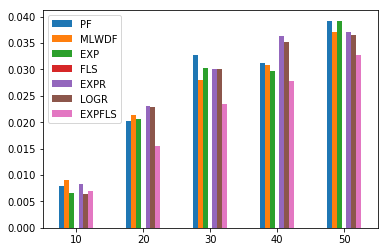

In [20]:
dfGPUTWEB = pd.DataFrame({'PF': MEGAWEB[1], 'MLWDF': MEGAWEB[2], 'EXP': MEGAWEB[3],
                       'FLS': MEGAWEB[4], 'EXPR': MEGAWEB[5], 'LOGR': MEGAWEB[6],
                        'EXPFLS': MEGAWEB[7]},
                      index=[10,20,30,40,50])
plot = dfGPUTWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTWeb.pdf", bbox_inches='tight')

## Delay

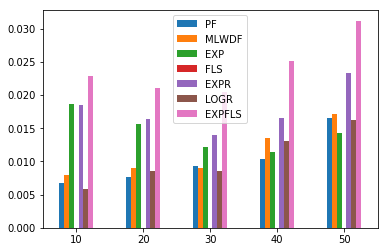

In [21]:
dfDELAYWEB = pd.DataFrame({'PF': DELAYWEB[1], 'MLWDF': DELAYWEB[2], 'EXP': DELAYWEB[3],
                            'FLS': DELAYWEB[4], 'EXPR': DELAYWEB[5], 'LOGR': DELAYWEB[6],
                             'EXPFLS': DELAYWEB[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayWeb.pdf", bbox_inches='tight')

## Jitter

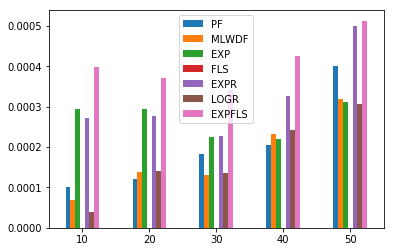

In [22]:
dfJITTERWEB = pd.DataFrame({'PF': JITTERWEB[1], 'MLWDF': JITTERWEB[2], 'EXP': JITTERWEB[3],
                            'FLS': JITTERWEB[4], 'EXPR': JITTERWEB[5], 'LOGR': JITTERWEB[6],
                            'EXPFLS': JITTERWEB[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterWebPF.pdf", bbox_inches='tight')

## FAIRNESS

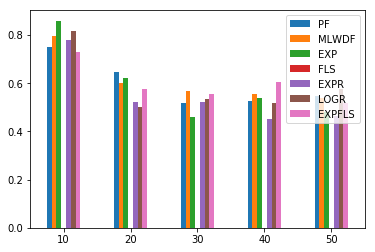

In [23]:
dfFAIRWEB = pd.DataFrame({'PF': FAIRWEB[1], 'MLWDF': FAIRWEB[2], 'EXP': FAIRWEB[3],
                            'FLS': FAIRWEB[4], 'EXPR': FAIRWEB[5], 'LOGR': FAIRWEB[6],
                            'EXPFLS': FAIRWEB[7]},
                           index=[10,20,30,40,50])
plot = dfFAIRWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessWeb.pdf", bbox_inches='tight')

## PLR

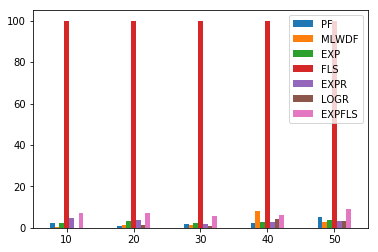

In [24]:
dfPLRWEB = pd.DataFrame({'PF': PLRWEB[1], 'MLWDF': PLRWEB[2], 'EXP': PLRWEB[3],
                            'FLS': PLRWEB[4], 'EXPR': PLRWEB[5], 'LOGR': PLRWEB[6],
                           'EXPFLS': PLRWEB[7]},
                           index=[10,20,30,40,50])
plot = dfPLRWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossWeb.pdf", bbox_inches='tight')

# CBR
## GPUT

In [25]:
MEGACBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for sched in GPUTSCBR:
    MEGACBR[sched] = np.true_divide(GPUTSCBR[sched], 1e+6)

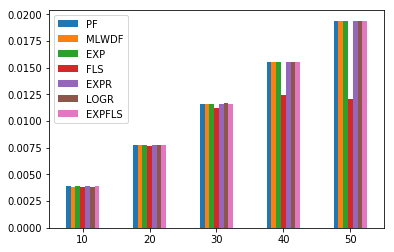

In [26]:
dfGPUTCBR = pd.DataFrame({'PF': MEGACBR[1], 'MLWDF': MEGACBR[2], 'EXP': MEGACBR[3],
                       'FLS': MEGACBR[4], 'EXPR': MEGACBR[5], 'LOGR': MEGACBR[6],
                        'EXPFLS': MEGACBR[7]},
                      index=[10,20,30,40,50])
plot = dfGPUTCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTCBR.pdf", bbox_inches='tight')

## Delay

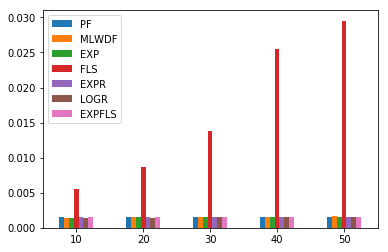

In [27]:
dfDELAYCBR = pd.DataFrame({'PF': DELAYCBR[1], 'MLWDF': DELAYCBR[2], 'EXP': DELAYCBR[3],
                            'FLS': DELAYCBR[4], 'EXPR': DELAYCBR[5], 'LOGR': DELAYCBR[6],
                             'EXPFLS': DELAYCBR[7]},
                           index=[10,20,30,40,50])
plot = dfDELAYCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayCBR.pdf", bbox_inches='tight')

## Jitter

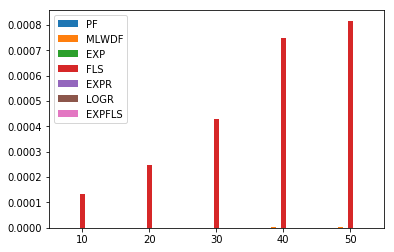

In [28]:
dfJITTERCBR = pd.DataFrame({'PF': JITTERCBR[1], 'MLWDF': JITTERCBR[2], 'EXP': JITTERCBR[3],
                            'FLS': JITTERCBR[4], 'EXPR': JITTERCBR[5], 'LOGR': JITTERCBR[6],
                            'EXPFLS': JITTERCBR[7]},
                           index=[10,20,30,40,50])
plot = dfJITTERCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterCBRPF.pdf", bbox_inches='tight')

## FAIRNESS

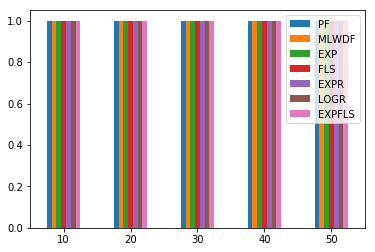

In [29]:
dfFAIRCBR = pd.DataFrame({'PF': FAIRCBR[1], 'MLWDF': FAIRCBR[2], 'EXP': FAIRCBR[3],
                            'FLS': FAIRCBR[4], 'EXPR': FAIRCBR[5], 'LOGR': FAIRCBR[6],
                            'EXPFLS': FAIRCBR[7]},
                           index=[10,20,30,40,50])
plot = dfFAIRCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessCBR.pdf", bbox_inches='tight')

## PLR

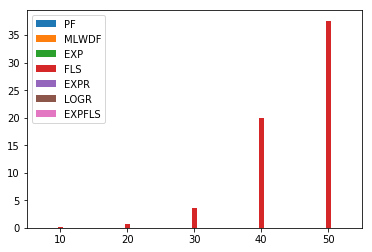

In [30]:
dfPLRCBR = pd.DataFrame({'PF': PLRCBR[1], 'MLWDF': PLRCBR[2], 'EXP': PLRCBR[3],
                            'FLS': PLRCBR[4], 'EXPR': PLRCBR[5], 'LOGR': PLRCBR[6],
                           'EXPFLS': PLRCBR[7]},
                           index=[10,20,30,40,50])
plot = dfPLRCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossCBR.pdf", bbox_inches='tight')

# Loss Ratio

In [31]:
averagePacketLoss = {}
for key in PACKETLOSS:
    averagePacketLoss[key] = []
    for i in range(0, 5):
        average = sum(PACKETLOSS[key][i])/len(PACKETLOSS[key][i])
        averagePacketLoss[key].append(average)

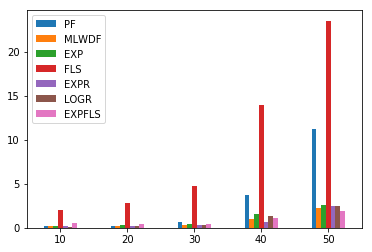

In [32]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1], 'MLWDF': averagePacketLoss[2], 'EXP': averagePacketLoss[3],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6],
                           'EXPFLS': averagePacketLoss[7]},
                           index=[10,20,30,40,50])
plot = dfLossRatio.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio.pdf", bbox_inches='tight')